# Proyecto Modulo 3: Clasificación de residuos mediante Aprendizaje por transferencia.

Descripción.
En este proyecto se desarrollara un modelo de clasificación un modelo de transferencia con el modelo pre-entrenado VGG16.


## Task.

Task 1: Print the version of tensorflow

Task 2: Create a test_generator using the test_datagen object

Task 3: Print the length of the train_generator

Task 4: Print the summary of the model

Task 5: Compile the model

Task 6: Plot accuracy curves for training and validation sets (extract_feat_model)

Task 7: Plot loss curves for training and validation sets (fine tune model)

Task 8: Plot accuracy curves for training and validation sets (fine tune model)

Task 9: Plot a test image using Extract Features Model (index_to_plot = 1)

Task 10: Plot a test image using Fine-Tuned Model (index_to_plot = 1)


In [29]:
# Importamos las librerias.
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn import metrics
import warnings
import os

Task 1: Print the version of tensorflow

In [3]:
tf.__version__

'2.18.0'

In [6]:
# Import Data
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 2528.21file/s]

Finished extracting file
Finished extracting file


In [39]:
model_config = {
    "img_size": (150, 150),
    "batch_size": 64,
    "epochs": 5,
    "n_classes": 2,
    "val_split": 0.2,
    "train_data_dir": "o-vs-r-split/train",
    "test_data_dir": "o-vs-r-split/test",
    "labels": ["orange", "red"],
    "seed": 42
}

# ImageDataGenerator
train_datagen = ImageDataGenerator(
    validation_split = model_config["val_split"],
    rescale = 1./255,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
    )

val_datagen = ImageDataGenerator(
    validation_split = model_config["val_split"],
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [16]:
train_generator = train_datagen.flow_from_directory(
    directory = model_config["train_data_dir"],
    seed = model_config["seed"],
    batch_size = model_config["batch_size"],
    class_mode = "binary",
    shuffle = True,
    target_size = model_config["img_size"],
    subset = "training"
)

val_generator = val_datagen.flow_from_directory(
    directory = model_config["train_data_dir"],
    seed = model_config["seed"],
    batch_size = model_config["batch_size"],
    class_mode = "binary",
    shuffle = True,
    target_size = model_config["img_size"],
    subset = "training"
)



Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Task 2: Create a test_generator using the test_datagen object

In [18]:
test_generator = test_datagen.flow_from_directory(
    directory = model_config["test_data_dir"],
    seed = model_config["seed"],
    batch_size = model_config["batch_size"],
    class_mode = "binary",
    shuffle = True,
    target_size = model_config["img_size"],
    subset = "training"
)

Found 200 images belonging to 2 classes.


Task 3: Print the length of the train_generator

In [19]:
len(train_generator)

25

Labels: ['O', 'O', 'O', 'O', 'O']


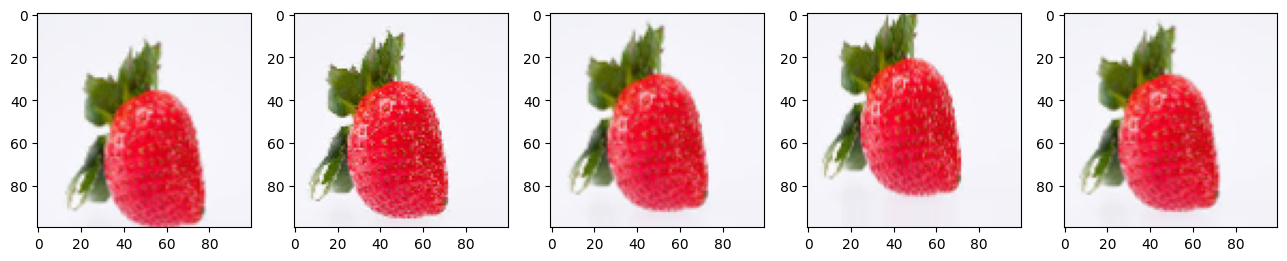

In [20]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

In [24]:
from tensorflow.keras.applications import VGG16

input_shape = (150, 150, 3)
# Cargamos el modelo VGG16 preentrenado
vgg = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)
# Congelamos las capas del modelo base
for layer in basemodel.layers:
    layer.trainable = False
# Creamos el modelo secuencial
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')
)



Task 4: Print the summary of the model

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_6 (Functional)       │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Task 5: Compile the model

In [28]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_path = 'model_checkpoint.keras'
# Definimo el callback LossHistory
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs = None):
        self.losses = []
        self.lr = []
    def on_epoch_end(self, epoch, logs=None):
        # logs contiene loss y accuracy de esa epoch
        self.losses.append(logs.get('loss'))
        lr_value = exp_decay(epoch)
        self.lr.append(lr_value)
        print(' Epoch:', epoch+1, ' - lr:', lr_value)
def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

loss_history = LossHistory()
lrate = LearningRateScheduler(exp_decay)
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min',min_delta=0.001),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
    lrate,
    loss_history
]


In [42]:
extract_feat_model = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // model_config["batch_size"],
    epochs = model_config["epochs"],
    validation_data = val_generator,
    validation_steps = val_generator.samples // model_config["batch_size"],
    callbacks = keras_callbacks
)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.9274 - loss: 0.1728Epoch: 1  - lr: 0.0001
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9276 - loss: 0.1732 - val_accuracy: 0.9609 - val_loss: 0.0988 - learning_rate: 1.0000e-04
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.9368 - loss: 0.1602Epoch: 2  - lr: 9.048374180359596e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9362 - loss: 0.1618 - val_accuracy: 0.9349 - val_loss: 0.1719 - learning_rate: 9.0484e-05
Epoch 3/5
 1/12 ━━━━━━━━━━━━━━━━━━━━ 9s 850ms/step - accuracy: 0.9062 - loss: 0.2740Epoch: 3  - lr: 8.187307530779819e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 890ms/step - accuracy: 0.9062 - loss: 0.2740 - val_accuracy: 0.9661 - val_loss: 0.0822 - learning_rate: 8.1873e-05
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.9577 - loss: 0.1343Epoch: 4  - lr: 7.408182206817179e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9572 - loss: 0.1359 - val_accuracy: 0.9531

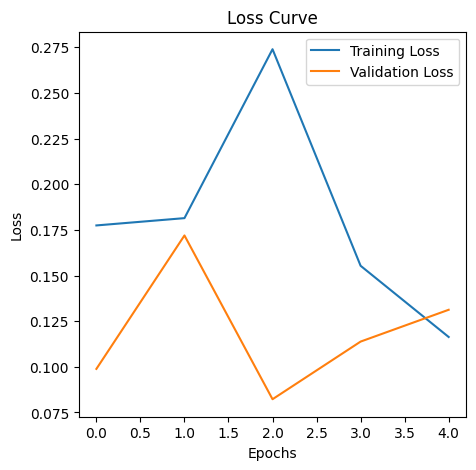

In [43]:
history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

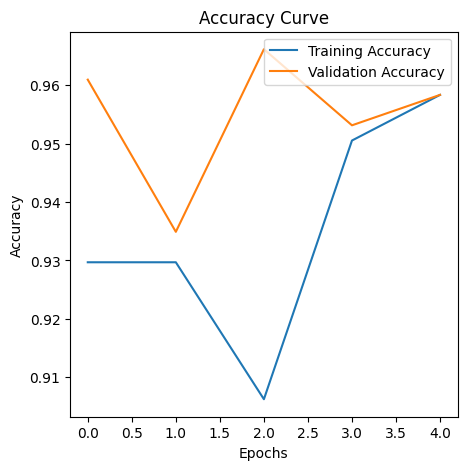

In [44]:
history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [46]:
from tensorflow.keras.applications import vgg16
input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_4',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_2']

input_layer_4: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_2: True


In [48]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=5, 
                    epochs=10,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples // model_config["batch_size"], 
                    verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5357 - loss: 0.7512Epoch: 1  - lr: 0.0001
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.5339 - loss: 0.7498 - val_accuracy: 0.6875 - val_loss: 0.5582 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7121 - loss: 0.5722Epoch: 2  - lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.7163 - loss: 0.5659 - val_accuracy: 0.8438 - val_loss: 0.4223 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8221 - loss: 0.4561Epoch: 3  - lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8215 - loss: 0.4518 - val_accuracy: 0.8307 - val_loss: 0.3795 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7791 - loss: 0.4064Epoch: 4  - lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7815 - loss: 0.4067 - val_accuracy: 0.8750 - val_loss: 0.3196 - learn

Task 7: Plot loss curves for training and validation sets (fine tune model)

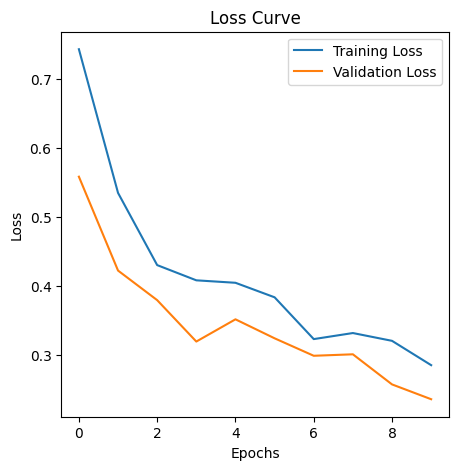

In [49]:
history = fine_tune_model
# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Task 8: Plot accuracy curves for training and validation sets (fine tune model)

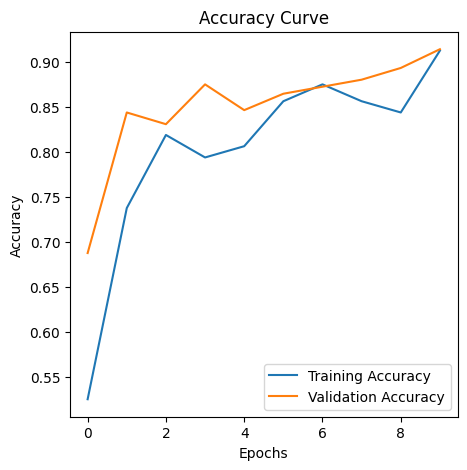

In [50]:
history = fine_tune_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [52]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('model_checkpoint.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.79      0.90      0.84        50
           R       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.76      0.88      0.81        50
           R       0.86      0.72      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100



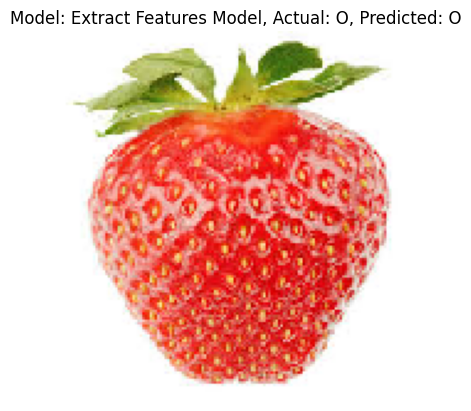

In [53]:
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

Task 9: Plot a test image using Extract Features Model (index_to_plot = 1)

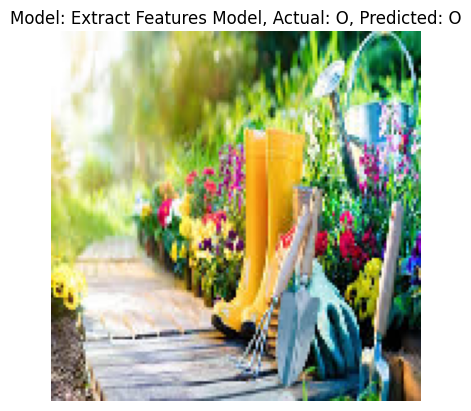

In [55]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

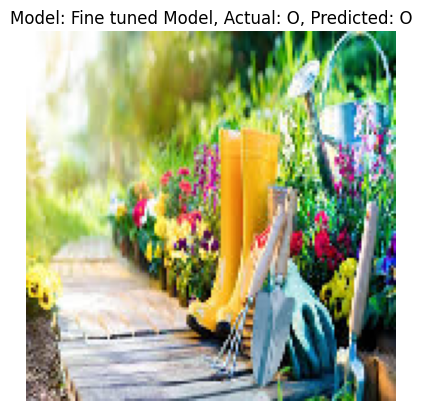

In [56]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine tuned Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )